In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extracting the dataset from the zip file
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/museum_train.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
# Normalized tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [6]:
dataset = ImageFolder(root='/content/museum_train', transform=transform)

In [7]:
indices = np.arange(len(dataset))

train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=dataset.targets, random_state=42)

# Create subsets
train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [8]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [9]:
class Model_1(nn.Module):
    def __init__(self, num_classes):
        super(Model_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
num_classes = len(dataset.classes)
model_1 = Model_1(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
num_epochs = 10

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1 = model_1.to(device)

for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_1(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

Epoch 1/10 | Loss: 0.3582 | Accuracy: 85.15%
Epoch 2/10 | Loss: 0.2795 | Accuracy: 89.26%
Epoch 3/10 | Loss: 0.2520 | Accuracy: 90.60%
Epoch 4/10 | Loss: 0.2260 | Accuracy: 91.31%
Epoch 5/10 | Loss: 0.1944 | Accuracy: 92.41%
Epoch 6/10 | Loss: 0.1688 | Accuracy: 93.79%
Epoch 7/10 | Loss: 0.1331 | Accuracy: 94.81%
Epoch 8/10 | Loss: 0.1054 | Accuracy: 96.12%
Epoch 9/10 | Loss: 0.0857 | Accuracy: 96.95%
Epoch 10/10 | Loss: 0.0645 | Accuracy: 97.64%


Evaluation Metrics:
Accuracy: 90.55%
Precision: 88.95%
Recall: 92.60%
F1 Score: 90.74%


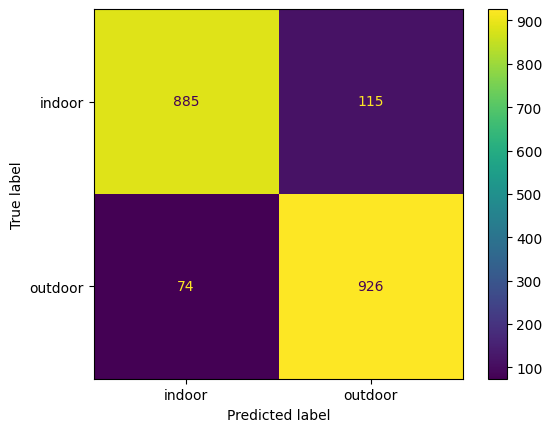

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes)

In [13]:
torch.save(model_1, "museum_detection_cnn_model_1.pth")

In [14]:
class Model_3(nn.Module):
    def __init__(self, num_classes):
        super(Model_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
num_classes = len(dataset.classes)
model_3 = Model_3(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.0005)
num_epochs = 10

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3 = model_3.to(device)

for epoch in range(num_epochs):
    model_3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_3(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

Epoch 1/10 | Loss: 0.3449 | Accuracy: 85.31%
Epoch 2/10 | Loss: 0.2631 | Accuracy: 89.96%
Epoch 3/10 | Loss: 0.2323 | Accuracy: 91.00%
Epoch 4/10 | Loss: 0.2065 | Accuracy: 92.08%
Epoch 5/10 | Loss: 0.1839 | Accuracy: 92.90%
Epoch 6/10 | Loss: 0.1514 | Accuracy: 94.03%
Epoch 7/10 | Loss: 0.1239 | Accuracy: 95.60%
Epoch 8/10 | Loss: 0.0951 | Accuracy: 96.42%
Epoch 9/10 | Loss: 0.0748 | Accuracy: 97.08%
Epoch 10/10 | Loss: 0.0503 | Accuracy: 98.21%


Evaluation Metrics:
Accuracy: 90.45%
Precision: 94.30%
Recall: 86.10%
F1 Score: 90.02%


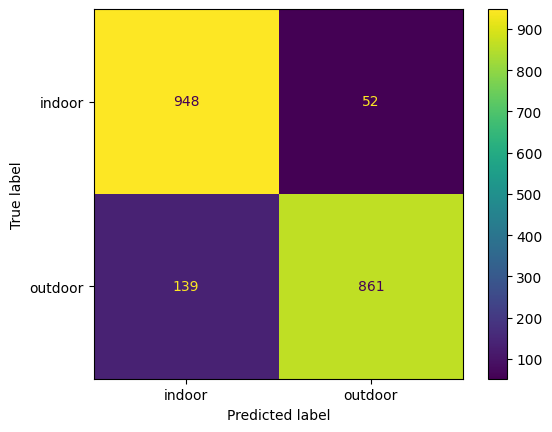

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_3(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1score * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes)

In [18]:
torch.save(model_3, "museum_detection_cnn_model_3.pth")